In [1]:
import sys
import json
import os

import torch
from torch.optim import Adam
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
import numpy as np

if r'G:\PythonProjects\WineRecognition2' not in sys.path:
    sys.path.insert(0, r'G:\PythonProjects\WineRecognition2')
from nn.utils import CustomDataset, train, plot_losses, generate_tag_to_ix, get_model_confidence, get_model_mean_confidence
from nn.model import BiLSTM_CRF
from nn.mlflow_utils import log_mlflow_on_train
from data_master import DataGenerator, count_unk_foreach_tag, DataAnalyzer

import wandb

from sklearn_crfsuite import metrics

D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
MODEL_NAME = 'BiLSTM_CRF'
RUN_NAME = f'train-H_WS_Brux_MenuSamples+USA+ENG+CAN_Num2Words_'
START_TIME = ''
OUTPUT_DIR = r'G:\PythonProjects\WineRecognition2\artifacts\train\test_exp'
DATASET_PATH = r'G:\PythonProjects\WineRecognition2\data\text\data_and_menu_gen_samples\Halliday_WineSearcher_Bruxelles_MenuGenSamples_v5_BottleSize_fixed.txt'
VOCAB_PATH = r'G:\PythonProjects\WineRecognition2\data\vocabs\Words_Halliday_WineSearcher_Bruxelles_WORD_NUMS.json'
DATAINFO_PATH = r'G:/PythonProjects/WineRecognition2/data_info.json'
DEVICE = 'cuda'
BATCH_SIZE = 2048
EMBEDDING_DIM = 64
HIDDEN_DIM = 64
NUM_EPOCHS = 3
LEARNING_RATE = 0.01
SCHEDULER_FACTOR = 0.1
SCHEDULER_PATIENCE = 10
CASE_SENSITIVE_VOCAB = False
USE_NUM2WORDS = False
WEIGHT_DECAY = 1e-4
TEST_SIZE = 0.2

In [3]:
params = {
    'model_name': MODEL_NAME,
    'dataset_path': DATASET_PATH,
    'vocab_path': VOCAB_PATH,
    'datainfo_path': DATAINFO_PATH,
    'device': DEVICE,
    'batch_size': BATCH_SIZE,
    'embedding_dim': EMBEDDING_DIM,
    'hidden_dim': HIDDEN_DIM,
    'num_epochs': NUM_EPOCHS,
    'learning_rate': LEARNING_RATE,
    'scheduler_factor': SCHEDULER_FACTOR,
    'scheduler_patience': SCHEDULER_PATIENCE,
    'case_sensitive_vocab': CASE_SENSITIVE_VOCAB,
    'weight_decay': WEIGHT_DECAY,
    'test_size': TEST_SIZE,
    'use_num2words': USE_NUM2WORDS,
    'run_info': {
        'name': RUN_NAME,
        'output_directory': OUTPUT_DIR,
        'start_time': START_TIME
    }
}

wandb.init(
    project="wine-recognition",
    config=params,
    tags=[MODEL_NAME, 'train'],
    dir=OUTPUT_DIR
)

wandb: Currently logged in as: mentalakv. Use `wandb login --relogin` to force relogin


In [4]:
with open(DATASET_PATH, encoding='utf-8') as file:
    sents = DataGenerator.generate_sents2(file.read().split('\n'))
    sents = sents[:10000]
    
dataset_artifact = wandb.Artifact('dataset', type='dataset')
dataset_artifact.add_file(DATASET_PATH, 'dataset.txt')
wandb.log_artifact(dataset_artifact)

len(sents)

10000

In [5]:
train_data, val_data = train_test_split(sents, test_size=TEST_SIZE)
len(train_data), len(val_data)

(8000, 2000)

In [6]:
with open(DATAINFO_PATH) as file:
    tag_to_ix = generate_tag_to_ix(json.load(file)['keys']['all'])

tags_path = os.path.join(OUTPUT_DIR, 'tags.json')
with open(tags_path, 'w', encoding='utf-8') as file:
    json.dump(tag_to_ix, file)

tags_artifact = wandb.Artifact('tags', type='dataset')
tags_artifact.add_file(tags_path, 'tags.json')
wandb.log_artifact(tags_artifact)

tag_to_ix

{'Add_TradeName': 0,
 'Add_Brand': 1,
 'Add_KeyWordTrue': 2,
 'Add_KeyWordFalse': 3,
 'Add_GrapeVarieties': 4,
 'Add_GeoIndication': 5,
 'Add_WineType': 6,
 'Add_BottleSize': 7,
 'Add_Sweetness': 8,
 'Add_WineColor': 9,
 'Add_ClosureType': 10,
 'Add_Certificate': 11,
 'Add_Vintage': 12,
 'Add_Price': 13,
 'Punctuation': 14,
 'Other': 15}

In [7]:
with open(VOCAB_PATH, 'r', encoding='utf-8') as file:
    word_to_ix = json.load(file)

vocab_artifact = wandb.Artifact('vocab', type='dataset')
vocab_artifact.add_file(VOCAB_PATH, 'vocab.json')
wandb.log_artifact(vocab_artifact)

len(word_to_ix)

18208

In [8]:
train_dataset = CustomDataset(
    train_data, tag_to_ix, word_to_ix, case_sensitive=CASE_SENSITIVE_VOCAB, convert_nums2words=USE_NUM2WORDS
)
val_dataset = CustomDataset(
    val_data, tag_to_ix, word_to_ix, case_sensitive=CASE_SENSITIVE_VOCAB, convert_nums2words=USE_NUM2WORDS
)

In [9]:
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True),
    'val': DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
}

In [10]:
vocab_size = len(word_to_ix)
model = BiLSTM_CRF(vocab_size, len(tag_to_ix), EMBEDDING_DIM, HIDDEN_DIM, padding_idx=word_to_ix['PAD']).to(DEVICE)
optimizer = Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = ReduceLROnPlateau(optimizer, factor=SCHEDULER_FACTOR, patience=SCHEDULER_PATIENCE)

In [11]:
model, losses = train(
    model,
    optimizer,
    dataloaders,
    DEVICE,
    NUM_EPOCHS,
    OUTPUT_DIR,
    scheduler=scheduler,
    tqdm=tqdm,
    log_wandb=True
)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1, train_loss: 59795.572916666664, val_loss: 45377.9765625
Epoch: 2, train_loss: 40053.369791666664, val_loss: 26103.16015625
Epoch: 3, train_loss: 22882.986979166668, val_loss: 14992.783203125


In [12]:
y_val_true = [tags for _, tags in val_dataset.raw_data()]

In [13]:
y_val_pred = []
tags = list(tag_to_ix.keys())
model.eval()
with torch.no_grad():
    for x_batch, y_batch, mask_batch, _ in dataloaders['val']:
        x_batch, mask_batch = x_batch.to(DEVICE), mask_batch.to(DEVICE)
        y_batch_pred = model(x_batch, mask_batch)
        y_val_pred.extend(y_batch_pred)
y_val_pred = [[tags[tag] for tag in sentence] for sentence in y_val_pred]

In [14]:
X_test = [
    torch.tensor(val_dataset.sentence_to_indices(sentence), dtype=torch.int64) for sentence, _ in val_dataset.raw_data()
]

In [15]:
unk_foreach_tag = count_unk_foreach_tag(X_test, y_val_true, list(tag_to_ix), val_dataset.word_to_ix[val_dataset.unk])

unk_foreach_tag_path = os.path.join(OUTPUT_DIR, 'unk_foreach_tag.json')
with open(unk_foreach_tag_path, 'w', encoding='utf-8') as file:
    json.dump(unk_foreach_tag, file)

unk_foreach_tag_artifact = wandb.Artifact('unk_foreach_tag', type='results')
unk_foreach_tag_artifact.add_file(unk_foreach_tag_path, 'unk_foreach_tag.json')
wandb.log_artifact(unk_foreach_tag_artifact)

<Artifact unk_foreach_tag>

In [16]:
conf = get_model_mean_confidence(model, X_test, DEVICE, tqdm)

0it [00:00, ?it/s]

D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\torchcrf\__init__.py:305: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at  ..\aten\src\ATen\native\TensorCompare.cpp:328.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)


In [17]:
test_eval = [list(zip(sentence, tags, y_val_pred[index])) for index, (sentence, tags) in enumerate(val_dataset.raw_data())]

In [18]:
labels=list(tag_to_ix)

wandb.log({'metrics': {
    'f1': metrics.flat_f1_score(y_val_true, y_val_pred, average='weighted', labels=labels),
    'precision': metrics.flat_precision_score(y_val_true, y_val_pred, average='weighted', labels=labels),
    'recall': metrics.flat_recall_score(y_val_true, y_val_pred, average='weighted', labels=labels),
    'accuracy': metrics.flat_accuracy_score(y_val_true, y_val_pred),
    'confidence': conf
}})

flat_class_report_path = os.path.join(OUTPUT_DIR, 'flat-classification-report.txt')
with open(flat_class_report_path, 'w', encoding='utf-8') as file:
    file.write(metrics.flat_classification_report(y_val_true, y_val_pred, labels=labels, digits=3))
    
flat_class_report_artifact = wandb.Artifact('flat_classification_report', type='results')
flat_class_report_artifact.add_file(flat_class_report_path, 'flat_classification_report.txt')
wandb.log_artifact(flat_class_report_artifact)

D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sklearn\metrics\_classification.py:1464: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(
D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\ProgramFiles\anaconda3\envs\wine-recognition\lib\site-packages\sk

<Artifact flat_classification_report>

<Artifact diagram>

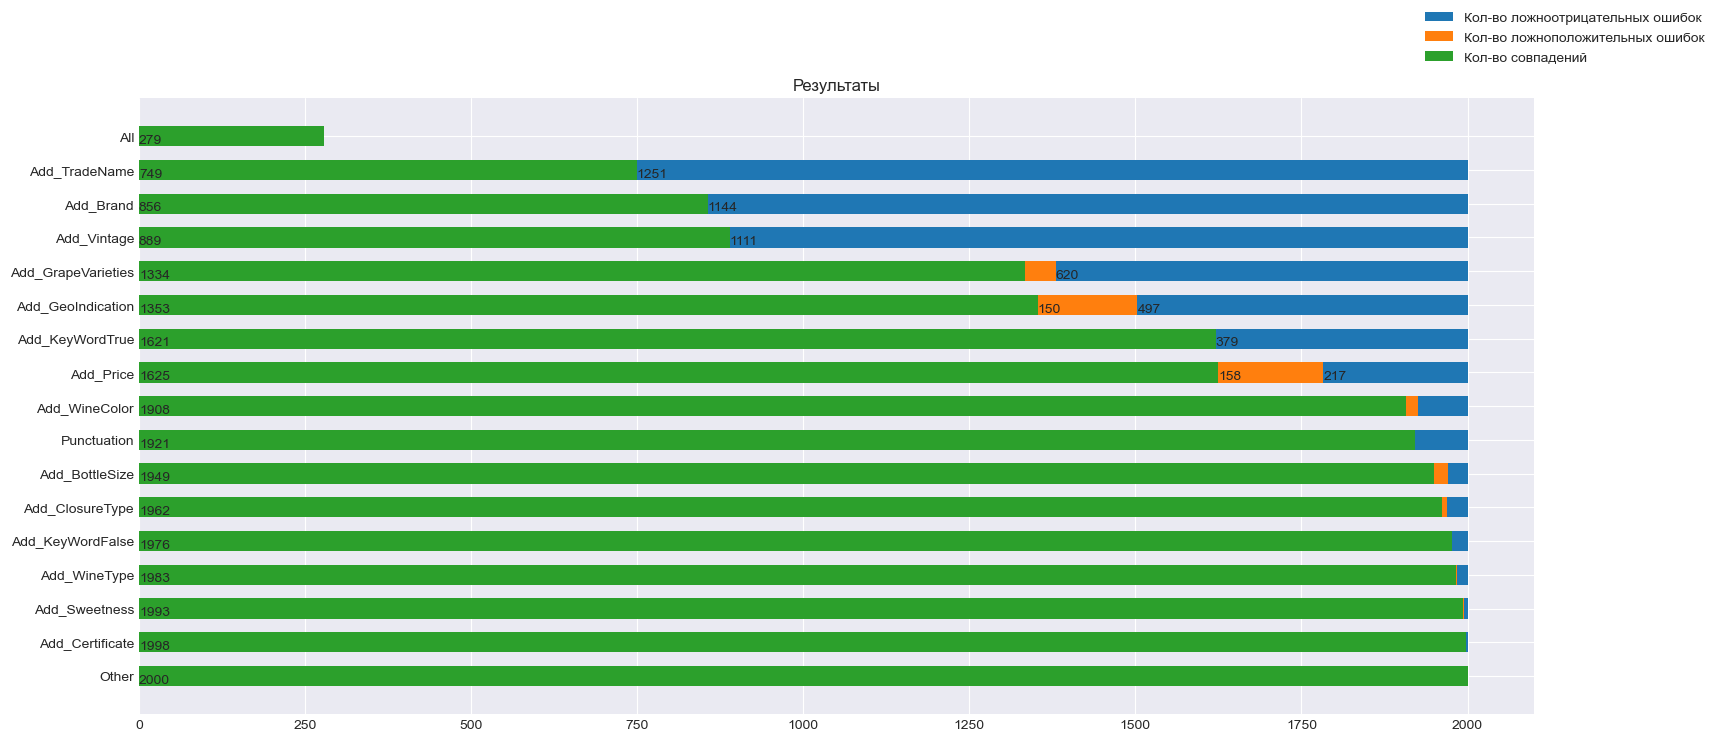

In [19]:
colored_table_path = os.path.join(OUTPUT_DIR, 'colored-table.xlsx')
diagram_path = os.path.join(OUTPUT_DIR, 'diagram.png')

DataAnalyzer.analyze(
        test_eval,
        keys=labels,
        table_save_path=colored_table_path,
        diagram_save_path=diagram_path)

colored_table_artifact = wandb.Artifact('colored_table', type='results')
colored_table_artifact.add_file(colored_table_path, 'colored-table.xlsx')
wandb.log_artifact(colored_table_artifact)

diagram_artifact = wandb.Artifact('diagram', type='results')
diagram_artifact.add_file(diagram_path, 'diagram.png')
wandb.log_artifact(diagram_artifact)

In [20]:
wandb.finish()

epoch,▁▅█
epoch,3
